In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from datetime import timedelta
import math
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import tol_colors as tc
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

In [ ]:
# note that proximal is what we refer to as the "closest-inferred ancestor" in the paper

hu1_og = readFASTA('../sarbecovirus_proximal_ancestors/data/SC2like_92bpGARD_050924/all_genomes_NRRs/hu1.fas')['hCoV-19/Wuhan/Hu-1/2019']
hu1_old = readFASTA('../sarbecovirus_proximal_ancestors/data/SC2like_92bpGARD_050924/all_genomes_NRRs/hu1.old.aln')['MN908947.3']
hu1_new = readFASTA('../sarbecovirus_proximal_ancestors/data/SC2like_92bpGARD_050924/all_genomes_NRRs/hu1.new.aln')['MN908947.3']

# map og to old, new
def map_og(og, other):
    og_to_other = {}
    index_og = 1
    for i in range(len(other)):
        if other[i] != '-' and other[i] != 'N':
            og_to_other[index_og] = i
            index_og += 1
    return og_to_other

og_to_old = map_og(hu1_og, hu1_old)
og_to_new = map_og(hu1_og, hu1_new)

# map old to new
old_to_og = {v: k for k, v in og_to_old.items()}
old_to_new = {}
for k, v in old_to_og.items():
    if v in og_to_new:
        old_to_new[k] = og_to_new[v]

def find_old_to_new(pos, old_to_new):
    if pos == 0:
        return 0
    if pos in old_to_new:
        return old_to_new[pos]
    else:
        print(f'Position {pos} not found in old_to_new')
        while pos not in old_to_new:
            pos += 1
            
            if pos > max(old_to_new.keys()):
                print(f'Need to return 32975 instead')
                return 32975
            
        print(f'Need to return {pos} instead')
        
        return old_to_new[pos]

### recombination figure details

In [3]:
sc1_like_bps_old = [0,1943,2809,3232,4073,5337,6141,6879,8286,8853,9162,10626,12774,14969,16034,17159,18849,19994,20495,21365,21813,23000,23812,24259,24904,26272,26656,27297,27880,29021,29395,31243]
sc2_like_bps_old = [0,1099,1829,2088,3181,3853,4426,5001,5571,8101,9027,9859,11994,12246,13086,15443,17498,18401,19886,20864,21735,22968,24036,25006,27842,28959,29380,31243]
genome_ann_old = [["Orf1ab",[465,21900]],["S",[21913,25893]],["Orf3a",[25903,26754]],["E",[26779,27009]],["M",[27060,27749]],["Orf6",[27760,28481]],["Orf7a",[28489,28866]],["Orf7b",[28863,28999]],["Orf8",[29006,29399]],["N",[29414,30687]],["Orf10",[30712,30832]]]
extra_feats_old = [["nsp2",[1005,2918],1],["nsp3",[2919,8890],1],["NTD",[22237,23201],0],["RBD",[23246,23978],0]]

sc1_like_bps = [0, 2090, 2977, 3400, 4268, 5532, 6336, 7074, 8481, 9048, 9357, 10821, 12969, 15164, 16229, 17354, 19044, 20189, 20690, 21560, 22008, 23212, 23979, 24420, 25065, 26427, 26811, 27452, 28035, 29176, 29561, 32975]
sc2_like_bps = [0, 1505, 1993, 2576, 3374, 4008, 4491, 5247, 5853, 6316, 7504, 7845, 8550, 9399, 10761, 12219, 12483, 13287, 15206, 15986, 16694, 17516, 18794, 20132, 20537, 21446, 21701, 21939, 22107, 23028, 23202, 25158, 25584, 25911, 26153, 26377, 26862, 27209, 27674, 28683, 29115, 29482, 29938, 30269, 32975]
genome_ann = [[x[0], [find_old_to_new(x[1][0], old_to_new), find_old_to_new(x[1][1], old_to_new)]] for x in genome_ann_old]
extra_feats = [[x[0], [find_old_to_new(x[1][0], old_to_new), find_old_to_new(x[1][1], old_to_new)], x[2]] for x in extra_feats_old]

spike_loc = genome_ann[1][1]
sc1_nrrs_spike = []
sc2_nrrs_spike = []
for i in range(len(sc1_like_bps)-1):
    if i == 0:
        continue
    if (sc1_like_bps[i-1] <= spike_loc[0] and sc1_like_bps[i] >= spike_loc[0]) or (sc1_like_bps[i-1] <= spike_loc[1] and sc1_like_bps[i] >= spike_loc[1]) or (sc1_like_bps[i] >= spike_loc[0] and sc1_like_bps[i] <= spike_loc[1]):
        sc1_nrrs_spike.append(i)

for i in range(len(sc2_like_bps)-1):
    if i == 0:
        continue
    if (sc2_like_bps[i-1] <= spike_loc[0] and sc2_like_bps[i] >= spike_loc[0]) or (sc2_like_bps[i-1] <= spike_loc[1] and sc2_like_bps[i] >= spike_loc[1]) or (sc2_like_bps[i] >= spike_loc[0] and sc2_like_bps[i] <= spike_loc[1]):
        sc2_nrrs_spike.append(i)

Position 23978 not found in old_to_new
Need to return 23984 instead


In [6]:
closebps = [4,20,21,24,25,26]
# closebps = [3, 6, 10, 13, 21, 25, 26]
closebps_old = []
for i, bp1 in enumerate(sc1_like_bps_old):
    if i == 0 or i == len(sc1_like_bps_old)-1:
        continue
    for j, bp2 in enumerate(sc2_like_bps_old):
        if abs(bp1-bp2) < 100:
            # print(f'{i} {j} {abs(bp1-bp2)}')
            closebps_old.append(j)
print(closebps == closebps_old)

closebps = [3, 6, 10, 13, 21, 25, 26]
closebps = []
for i, bp1 in enumerate(sc1_like_bps):
    if i == 0 or i == len(sc1_like_bps)-1:
        continue
    for j, bp2 in enumerate(sc2_like_bps):
        if abs(bp1-bp2) < 52:
            # print(f'{i} {j} {abs(bp1-bp2)}')
            closebps.append(i)
closebps

True


[3, 6, 10, 13, 21, 25, 26]

## tProximal functions

In [7]:
def toDatestring(yearFraction):
    year = math.floor(yearFraction)
    remaining_days = (yearFraction-year)*365
    datestring = str(dt(year,1,1) + timedelta(remaining_days))[:10]
    return datestring


def load_data(directory, sc, pre='NRR'):
    combined_df = pd.DataFrame()
    column = 'age(sc%i)' % sc
    burnins = pd.read_csv(os.path.join(directory,'burnins.tsv'), sep='\t')
    for row in burnins.iterrows():
        if row[1]['min_burnin_percent'] < 0 or ('+' in row[1]['file']):
            continue
        print('Loading %s' % row[1]['file'])
        nrr = row[1]['file'].split(pre)[-1].split('.')[0].split('_')[0]
        df = pd.read_csv(os.path.join(directory, row[1]['file']), sep='\t', comment='#').iloc[(row[1]['min_burnin_states']):]
        combined_df[nrr] = df[column]
    return combined_df

def generate_tProximal_df(directory, sc):
    sc_df = load_data(directory, sc)
    sc_all_df = pd.DataFrame()
    sc_95hpd_df = pd.DataFrame()
    sc_tmrca_string_summary = []
    sc_tmrca_medians = {}
    sc_95hpd_vals = {}
    for col in sc_df.columns:
        temp = sc_df[col][~sc_df[col].isna()]
        hpd_vals = hpd_single(temp, 0.05)
        median = np.median(temp)
        temp_95hpd = [x for x in temp if x > hpd_vals[0] and x < hpd_vals[1]]
        if len(temp_95hpd) < len(sc_95hpd_df):
            temp_95hpd += ([np.nan] * (len(sc_95hpd_df) - len(temp_95hpd)))
        sc_95hpd_df[col] = temp_95hpd
        sc_all_df[col] = temp
        sc_tmrca_string_summary.append([col, ('%s (%s to %s)' % (toDatestring(median), toDatestring(hpd_vals[0]), toDatestring(hpd_vals[1])))])
        sc_tmrca_medians[int(col)] = median
        sc_95hpd_vals[int(col)] = hpd_vals

    return sc_all_df, sc_95hpd_df, sc_tmrca_medians, sc_95hpd_vals


sc1_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC1'
sc2_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC2_late2020/'
sc2_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC2_late2020_revision/SC2_late_transfer/'
sc2_early_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC2_early2020_revision/SC2_early_transfer/'
sc1_extra_seqs_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC1_extraSeqs_revision/combined/'
sc1_all_df, sc1_95hpd_df, sc1_tmrca_medians, sc1_hpd_vals = generate_tProximal_df(sc1_directory, 1)
sc2_all_df, sc2_95hpd_df, sc2_tmrca_medians, sc2_hpd_vals = generate_tProximal_df(sc2_directory, 2)
sc2_early_all_df, sc2_early_95hpd_df, sc2_early_tmrca_medians, sc2_early_hpd_vals = generate_tProximal_df(sc2_early_directory, 2)
sc1_extra_seqs_all_df, sc1_extra_seqs_95hpd_df, sc1_extra_seqs_tmrca_medians, sc1_extra_seqs_hpd_vals = generate_tProximal_df(sc1_extra_seqs_directory, 1)

Loading SC1.NRR01.log
Loading SC1.NRR02.log
Loading SC1.NRR03.log
Loading SC1.NRR04.log
Loading SC1.NRR05.log
Loading SC1.NRR06.log
Loading SC1.NRR07.log
Loading SC1.NRR08.log
Loading SC1.NRR09.log
Loading SC1.NRR10.log
Loading SC1.NRR11.log
Loading SC1.NRR12.log
Loading SC1.NRR13.log
Loading SC1.NRR14.log
Loading SC1.NRR15.log
Loading SC1.NRR16.round2.log
Loading SC1.NRR17.log
Loading SC1.NRR18.log
Loading SC1.NRR19.log
Loading SC1.NRR20.log
Loading SC1.NRR21.log
Loading SC1.NRR22.log
Loading SC1.NRR23.log
Loading SC1.NRR24.log
Loading SC1.NRR25.log
Loading SC1.NRR26.log
Loading SC1.NRR27.log
Loading SC1.NRR28.log
Loading SC1.NRR29.log
Loading SC1.NRR30.log
Loading SC1.NRR31.log
Loading SC2_NRR1_hmm.edit.log
Loading SC2_NRR2_hmm.edit.log
Loading SC2_NRR3_hmm.edit.log
Loading SC2_NRR4_hmm.edit.log
Loading SC2_NRR5_hmm.edit.log
Loading SC2_NRR6_hmm.edit.log
Loading SC2_NRR7_hmm.edit.log
Loading SC2_NRR8_hmm.edit.log
Loading SC2_NRR9_hmm.edit.log
Loading SC2_NRR10_hmm.edit.log
Loading SC

# Combine with timing figures

['nsp2', [1152, 3086], 1]
['nsp3', [3087, 9085], 1]
['NTD', [22439, 23413], 0]
['RBD', [23458, 24145], 0]


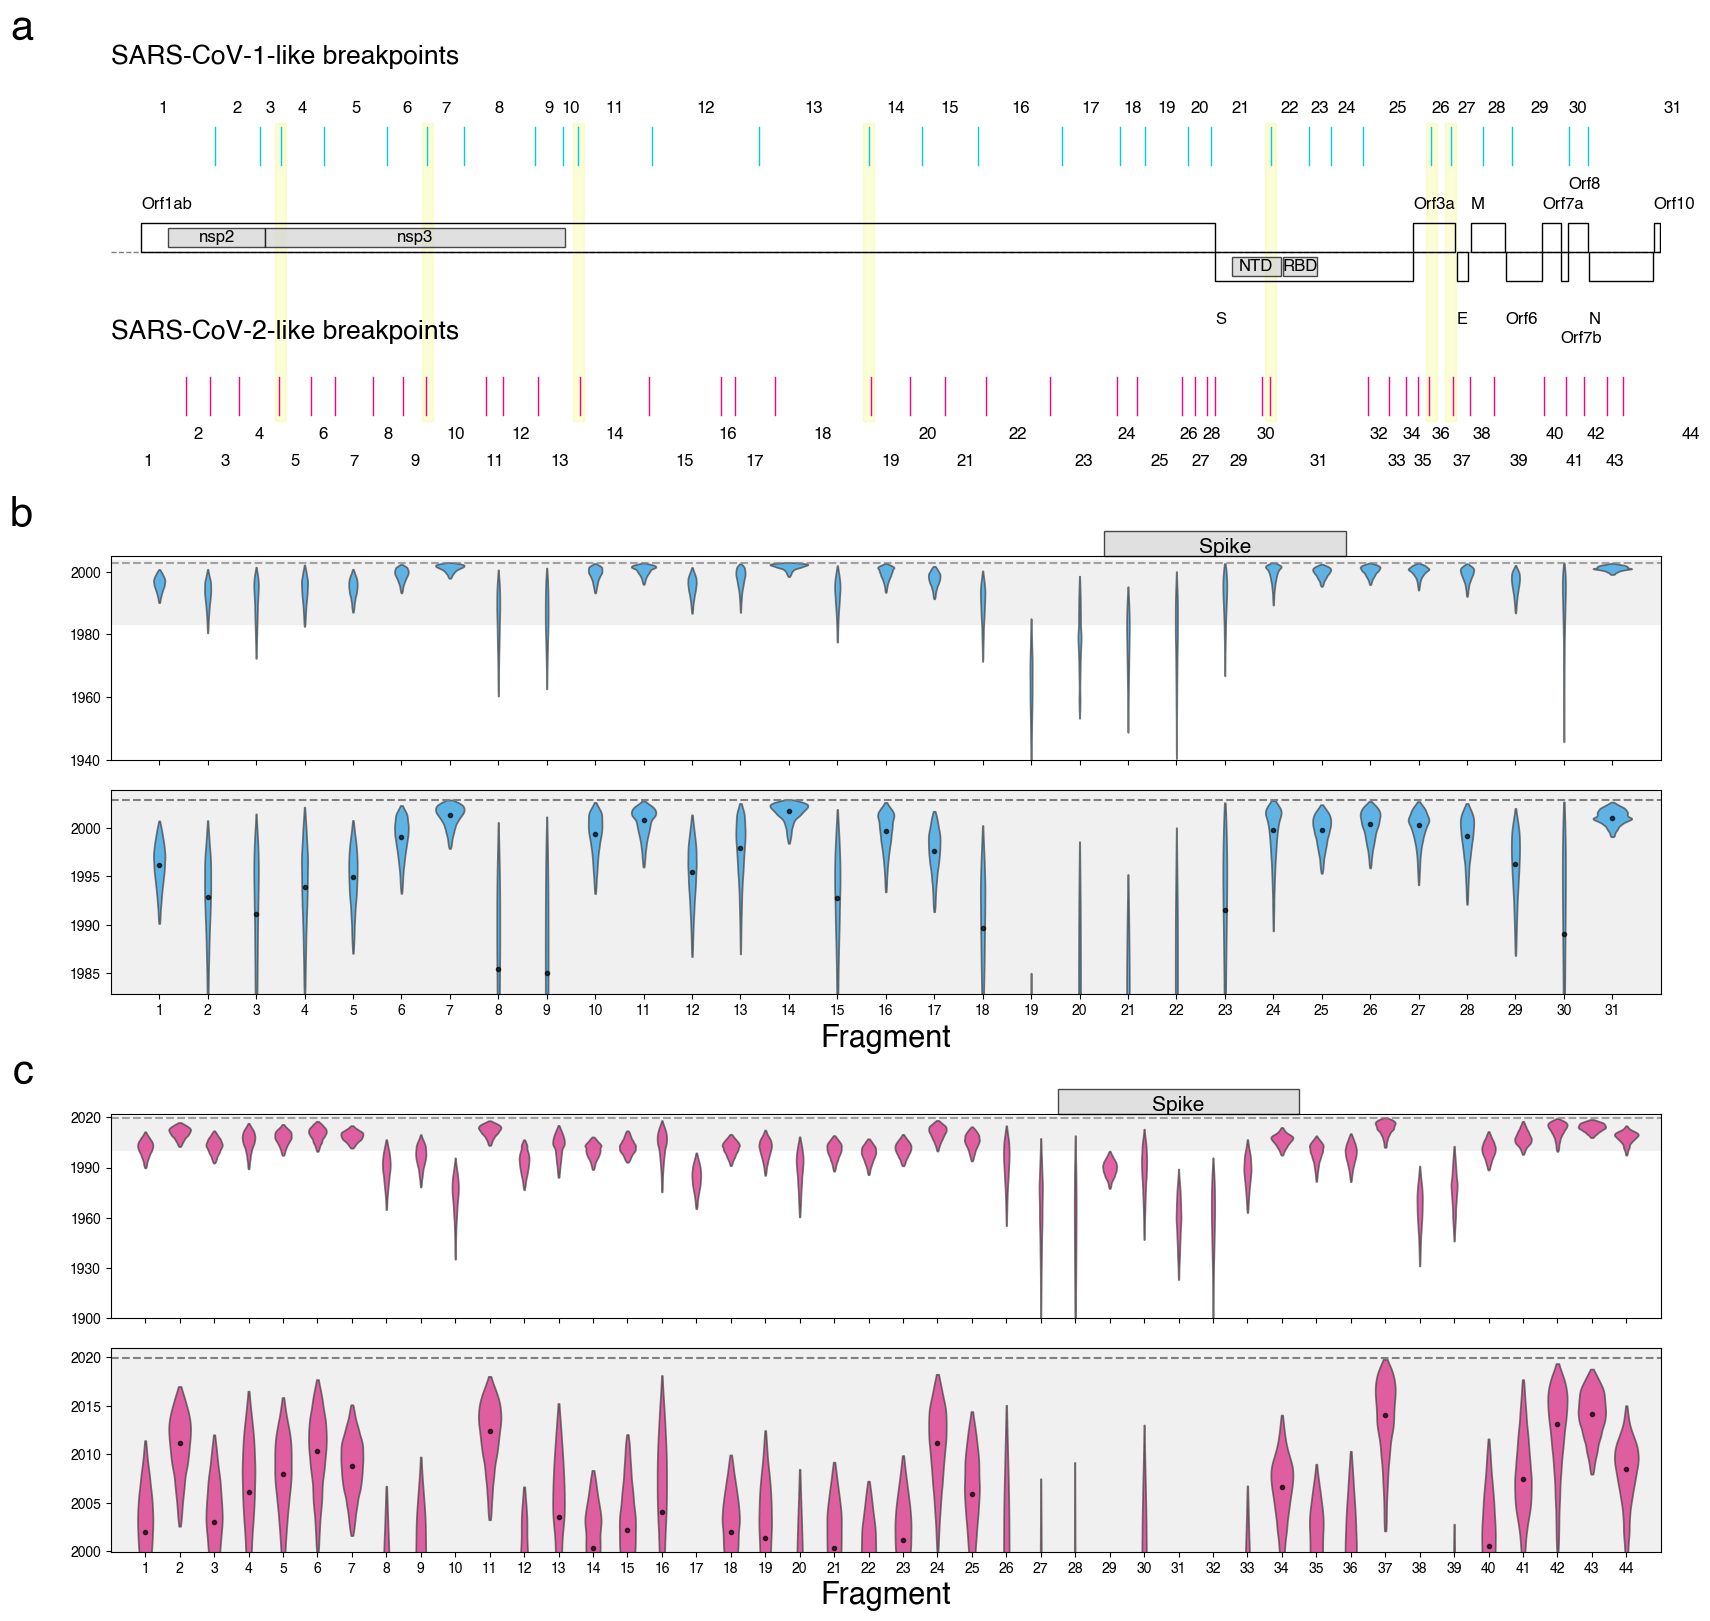

In [10]:
def plot_tPrimary(sc_95hpd_df, sc_tmrca_medians, sc, ax1, ax2, facecolor='lightgrey', include_top_panel_xticklabels=False, color='grey', alpha=0.7):
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 

    if sc == 1:
        large_year_spacing = [1940,1960,1980,2000]
        first_sc_case_date = toYearFraction('2002-11-16')
        small_year_spacing = [first_sc_case_date-20,first_sc_case_date+1]
        num_regions = 31
    elif sc == 2:
        large_year_spacing = [1900,1930,1960,1990,2020]
        first_sc_case_date = toYearFraction('2019-12-10')
        small_year_spacing = [first_sc_case_date-20,first_sc_case_date+1]
        num_regions = 44


    sns.violinplot(  data = sc_95hpd_df,  orient='v', inner=None, color=color, ax=ax1, cut=0)
    sns.violinplot(  data = sc_95hpd_df,  orient='v', inner=None, color=color, ax=ax2, cut=0)
    ax2.scatter([x-1 for x in sc_tmrca_medians.keys()], sc_tmrca_medians.values(), marker='.', color='black', alpha=0.5)
    ax1.hlines(first_sc_case_date, -1, num_regions + 1, linestyle='--', color='grey')
    ax1.set_xlim(-1,num_regions)
    ax1.set_xticklabels(labels=[])
    ax1.set_yticks(large_year_spacing)
    ax1.set_ylim(large_year_spacing[0], first_sc_case_date+2)

    for violin in ax1.collections[::]:
        violin.set_alpha(alpha)
    for violin in ax2.collections[::]:
        violin.set_alpha(alpha)

    if include_top_panel_xticklabels:
        ax1.set_xticklabels(labels=[x for x in sc_tmrca_medians.keys()])
    # ax2.set_xticklabels(labels=[x for x in sc_tmrca_medians.keys()])
    ax2.set_xlabel('Fragment', fontsize=22)
    ax2.hlines(first_sc_case_date, -1, num_regions + 1, linestyle='--', color='grey')
    ax2.set_xlim(-1,num_regions)
    ax2.set_yticks([x for x in range(1980,2025,5)])
    ax2.set_ylim(small_year_spacing)

    # Set the xticks first
    ax2.set_xticks([x-1 for x in sc_tmrca_medians.keys()])
    ax2.set_xticklabels([x for x in sc_tmrca_medians.keys()])


    # make grey box in first panel to show where second panel is
    ax1.add_patch(
        patches.Rectangle(
            (-1, small_year_spacing[0]),   # (x,y)
            len(sc_tmrca_medians) + 2,          # width
            small_year_spacing[1]-small_year_spacing[0],          # height
            facecolor=facecolor,
            edgecolor='none',
            zorder=0
        )
    )
    
    ax2.set_facecolor(facecolor)
    return ax1, ax2


w = 600
h = 300
marg = 0

plt.figure(figsize=(w/30, 5*h/80))
plt.subplots_adjust(hspace=.3)
gs1 = GridSpec(5, 1)

#make outer gridspec
outer = gridspec.GridSpec(3, 1, height_ratios = [1.5,2,2]) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = .25)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = .15)
gs3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[2], hspace = .15)

ax00 = plt.subplot(gs1[0])
ax01 = plt.subplot(gs2[0])
ax02 = plt.subplot(gs2[1])
ax03 = plt.subplot(gs3[0])
ax04 = plt.subplot(gs3[1])
axes = [ax00, ax01, ax02, ax03, ax04]

############################################################################################################################################################################
########################################################################## panel 1: recombination ##########################################################################
############################################################################################################################################################################

genomefit = (w-2*marg)/sc2_like_bps[-1]
bpheight = 20
fontsize = 12
large_fontsize = 19


# SC2 bps
for i in range(1, len(sc2_like_bps) - 1):
    axes[0].plot([marg + sc2_like_bps[i]*genomefit, marg + sc2_like_bps[i]*genomefit], [h/3 - bpheight, h/3], color='#f50280', linewidth=1)

# SC2 NRR numbering
for i in range(1, len(sc2_like_bps)):
    if i % 2 == 0:
        ypos = h/3 - bpheight*1.3
    else:
        ypos = h/3 - bpheight*2
    axes[0].text(marg + sc2_like_bps[i-1]* genomefit + ((sc2_like_bps[i] - sc2_like_bps[i-1])/2)*genomefit, ypos, i, color='black', fontsize=fontsize, horizontalalignment='center', verticalalignment='top')

axes[0].text(0 + marg, h/3 + bpheight*1.5, 'SARS-CoV-2-like breakpoints', color='black', fontsize=large_fontsize, horizontalalignment='left', verticalalignment='top')

# SC1 bps
for i in range(1, len(sc1_like_bps) - 1):
    if i in closebps:
        axes[0].add_patch(plt.Rectangle((marg + sc1_like_bps[i]*genomefit - 2, h/3 - bpheight - 3), 4, 2*h/3 + bpheight - 65, color='#f4fa7a', alpha=0.3))
    axes[0].plot([marg + sc1_like_bps[i]*genomefit, marg + sc1_like_bps[i]*genomefit], [2*h/3 + 10, 2*h/3 + 10 + bpheight], color='#00cce3', linewidth=1)

# SC1 NRR numbering
for i in range(1, len(sc1_like_bps)):
    axes[0].text(marg + sc1_like_bps[i-1]* genomefit + ((sc1_like_bps[i] - sc1_like_bps[i-1])/2)*genomefit, 2*h/3 + 10 + bpheight*1.3, i, color='black', fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')

axes[0].text(0 + marg, 2*h/3 + 10 + bpheight*2.5, 'SARS-CoV-1-like breakpoints', color='black', fontsize=large_fontsize, horizontalalignment='left', verticalalignment='bottom')

# ORF diagram
for i, o in enumerate(genome_ann):
    x = marg + (o[1][0] * genomefit)
    y = h / 2 if genome_ann.index(o) % 2 == 1 else h / 2 + 15
    width = (o[1][1] - o[1][0]) * genomefit
    height = 15

    axes[0].add_patch(plt.Rectangle((x, y), width, height, fill=None, color="black", linewidth=1))

    x_text = marg + (o[1][0] * genomefit)
    y_text = h / 2 - 20 if genome_ann.index(o) % 2 == 1 else h / 2 + 40
    if o[0] == 'Orf7b':
        y_text = h / 2 - 30
    elif o[0] == 'Orf8':
        y_text = h / 2 + 50
    
    axes[0].text(x_text, y_text, o[0], fontsize=fontsize, color="black", horizontalalignment='left', verticalalignment='center')
axes[0].hlines(h/2 + 15, marg, genomefit*31017 + marg, color='grey', linewidth=1, linestyle='dashed', zorder=0)

for e in extra_feats:
    print(e)
    x = marg + (e[1][0] * genomefit)
    y = h / 2 + 2.5 + (e[2] * 15)
    width = (e[1][1] - e[1][0]) * genomefit
    height = 10

    axes[0].add_patch(plt.Rectangle((x, y), width, height, fc="lightgrey", alpha=0.7, ec="black", linewidth=1))
    axes[0].text(x + width/2, y + height/2, e[0], fontsize=fontsize, color="black", horizontalalignment='center', verticalalignment='center')

# adjust axes, remove all axes and ticks
axes[0].set_xlim(0, genomefit*31017 + marg)
axes[0].axes.get_xaxis().set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)


############################################################################################################################################################################
########################################################################## panel 2: tProximal, SC1 #########################################################################
############################################################################################################################################################################
fontsize=15
facecolor = [(mpl.colors.to_rgb('whitesmoke')[0] + mpl.colors.to_rgb('lightgrey')[0])/2] * 3
facecolor = [0.94] * 3
sc2_color = '#f50280'
sc1_color = '#00a0ff'


ax1, ax2 = plot_tPrimary(sc1_95hpd_df, sc1_tmrca_medians, 1, axes[1], axes[2], facecolor=facecolor, color=sc1_color, alpha=0.7)

# add box above NRRs 21-25 in ax1 to indicate that this is the spike gene
ax1.add_patch(plt.Rectangle(((sc1_nrrs_spike[0]-0.5)/32, 1), 5/32, .125, transform=ax1.transAxes, fill=True, facecolor='lightgrey', alpha=0.7, edgecolor='black', linewidth=1, clip_on=False))
ax1.text(((sc1_nrrs_spike[0]-0.5) + 5/2)/32, 1, 'Spike', color='black', transform=ax1.transAxes, fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')


############################################################################################################################################################################
########################################################################## panel 3: tProximal, SC2 #########################################################################
############################################################################################################################################################################

ax1, ax2 = plot_tPrimary(sc2_95hpd_df, sc2_tmrca_medians, 2, axes[3], axes[4], facecolor=facecolor, color=sc2_color, alpha=0.7)

# add box above NRRs 21-24 in ax1 to indicate that this is the spike gene
ax1.add_patch(plt.Rectangle(((sc2_nrrs_spike[0]-0.5)/(44+1), 1), len(sc2_nrrs_spike)/(44+1), .125, transform=ax1.transAxes, fill=True, facecolor='lightgrey', alpha=0.7, edgecolor='black', linewidth=1, clip_on=False))
ax1.text((((sc2_nrrs_spike[0]-0.5)) + len(sc2_nrrs_spike)/2)/(44+1), 1, 'Spike', color='black', transform=ax1.transAxes, fontsize=fontsize, horizontalalignment='center', verticalalignment='bottom')


axes[0].text(-0.05, 1.3, 'a', transform=axes[0].transAxes, fontsize=30, va='top', ha='right', weight='bold')
axes[1].text(-0.05, 1.3, 'b', transform=axes[1].transAxes, fontsize=30, va='top', ha='right', fontweight='bold')
axes[3].text(-0.05, 1.3, 'c', transform=axes[3].transAxes, fontsize=30, va='top', ha='right', fontweight='bold')

# sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})


# plt.savefig('../sarbecovirus_proximal_ancestors/figures/figure1.png', dpi=300, bbox_inches='tight')
plt.savefig('../sarbecovirus_proximal_ancestors/figures/figure1.pdf', dpi=300, bbox_inches='tight')

# Comparison of all analyses

In [11]:
sc2_combined_df = pd.DataFrame()
sc2_combined_df['NRR'] = sc2_tmrca_medians.keys()
sc2_combined_df['SC2_late2020.median'] = [sc2_tmrca_medians[x] for x in sc2_tmrca_medians.keys()]
sc2_combined_df['SC2_late2020.95%HPD'] =  [sc2_hpd_vals[x] for x in sc2_tmrca_medians.keys()]
sc2_combined_df['SC2_early2020.median'] = [sc2_early_tmrca_medians[x] for x in sc2_tmrca_medians.keys()]
sc2_combined_df['SC2_early2020.95%HPD'] = [sc2_early_hpd_vals[x] for x in sc2_tmrca_medians.keys()]

sc1_combined_df = pd.DataFrame()
sc1_combined_df['NRR'] = sc1_tmrca_medians.keys()
sc1_combined_df['SC1.median'] = [sc1_tmrca_medians[x] for x in sc1_tmrca_medians.keys()]
sc1_combined_df['SC1.95%HPD'] =  [sc1_hpd_vals[x] for x in sc1_tmrca_medians.keys()]
sc1_combined_df['SC1_extraSeqs.median'] = [sc1_extra_seqs_tmrca_medians[x] for x in sc1_tmrca_medians.keys()]
sc1_combined_df['SC1_extraSeqs.95%HPD'] = [sc1_extra_seqs_hpd_vals[x] for x in sc1_tmrca_medians.keys()]

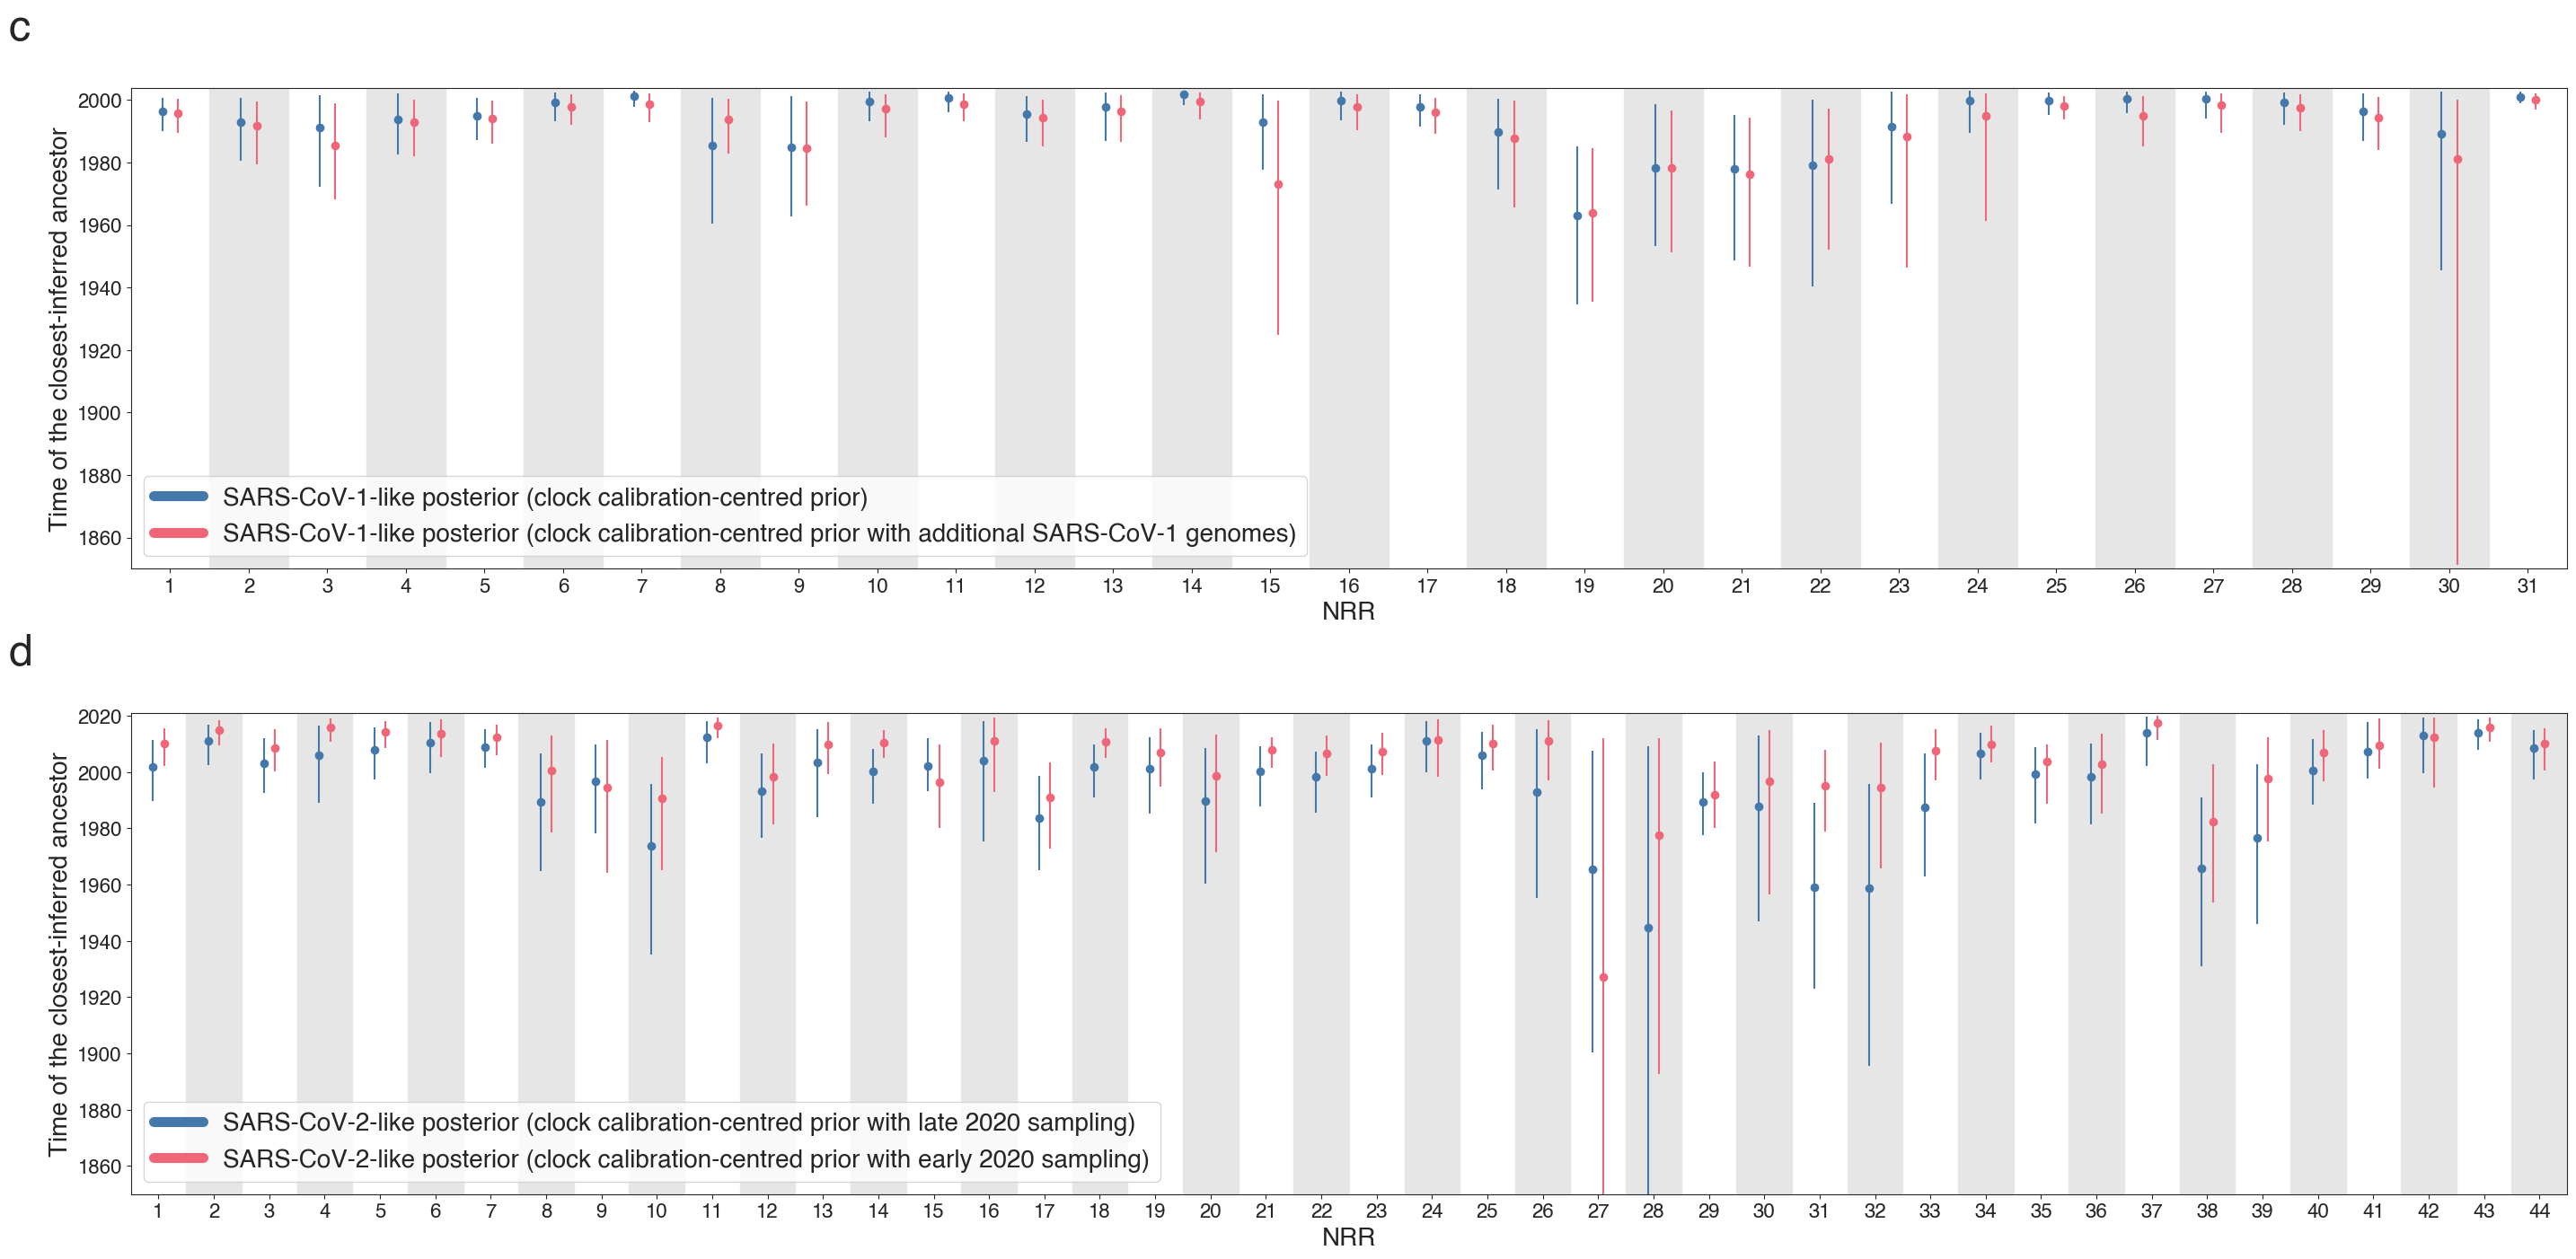

In [ ]:
def plot_tPrimaries(combined_df, ax, label1, label2, sc):
    '''
    Plot the tPrimary for each NRR
    '''
    # fig, ax = plt.subplots(1, 1, figsize=(40,8), facecolor='white')
    num_results = len([x for x in combined_df.columns if 'median' in x or 'mean' in x])
    cset = tc.tol_cset('bright')
    # print(num_results)
    for index, row in combined_df.iterrows():
        # add grey column for even nrrs
        # grey column for even nrrs
        if row['NRR'] % 2 == 0:
            ax.add_patch(patches.Rectangle((row['NRR']-0.5, 0), 1, 2024, color='0.9'))

        x_locs = np.linspace(row['NRR']-(num_results*0.1)/2, row['NRR']+(num_results*0.1)/2, num_results)

        ax.scatter(x_locs[0], row[combined_df.columns[1]], color=cset[0], label=label1)
        ax.vlines(x_locs[0], row[combined_df.columns[2]][0], row[combined_df.columns[2]][1], color=cset[0])

        ax.scatter(x_locs[1], row[combined_df.columns[3]], color=cset[1], label=label2)
        ax.vlines(x_locs[1], row[combined_df.columns[4]][0], row[combined_df.columns[4]][1], color=cset[1])

    # create custom legend for these 3-4 analyses
    custom_lines = [Line2D([0], [0], color=cset[0], lw=8),
                    Line2D([0], [0], color=cset[1], lw=8)]
    legend_labels = [label1, label2] 
    
    ax.legend(custom_lines, legend_labels, loc='lower left', fontsize=20)

    ax.set_xlim([0.5,len(combined_df)+0.5])

    ax.set_xlabel('NRR', fontsize=20)
    ax.set_ylabel('Time of the closest-inferred ancestor', fontsize=20)
    ax.set_xticks(combined_df['NRR'])
    ax.tick_params(axis='both', which='major', labelsize=16)

    ymin = 2999
    ymax = 0
    for index, row in combined_df.iterrows():
        if row[combined_df.columns[2]][0] < ymin:
            ymin = row[combined_df.columns[2]][0]
        if row[combined_df.columns[4]][0] < ymin:
            ymin = row[combined_df.columns[4]][0]
        if row[combined_df.columns[2]][1] > ymax:
            ymax = row[combined_df.columns[2]][1]
        if row[combined_df.columns[4]][1] > ymax:
            ymax = row[combined_df.columns[4]][1]
    ymin -= 10
    ymax += 1
    ax.set_ylim([1850, ymax])
    # ax.set_ylim([1900, ymax])

    # gridlines
    ax1.grid(axis='both', linestyle='--')
    ax2.grid(axis='y', linestyle='--')


sns.set_style("ticks")
plt.rcParams['font.sans-serif'] = "Helvetica"
fig, axes = plt.subplots(2, 1, figsize=(35,16), facecolor='white')
axes[0].text(-0.05, 1.1, 'c', transform=axes[0].transAxes, size=35)
axes[1].text(-0.05, 1.1, 'd', transform=axes[1].transAxes, size=35)
plt.subplots_adjust(hspace=0.3)
plot_tPrimaries(sc1_combined_df, 
                ax=axes[0],
                label1='SARS-CoV-1-like posterior (clock calibration-centred prior)',
                label2='SARS-CoV-1-like posterior (clock calibration-centred prior with additional SARS-CoV-1 genomes)',
                sc=1)
plot_tPrimaries(sc2_combined_df, 
                ax=axes[1],
                label2='SARS-CoV-2-like posterior (clock calibration-centred prior with early 2020 sampling)',
                label1='SARS-CoV-2-like posterior (clock calibration-centred prior with late 2020 sampling)',
                sc=2)

# plt.savefig('../sarbecovirus_proximal_ancestors/figures/FigSX_SC1_SC2_tProximal_sensitivity.pdf', dpi=300, bbox_inches='tight')

# make bottom 1850 for both

# Table

In [18]:
# apply floor to all values
def floor_df_values(combined_df):
    for col in combined_df.columns:
        if 'median' in col:
            combined_df[col] = combined_df[col].apply(lambda x: math.floor(x))
        elif 'NRR' not in col:
            combined_df[col] = combined_df[col].apply(lambda x: [math.floor(y) for y in x])
    return combined_df


sc1_combined_df = floor_df_values(sc1_combined_df)
sc2_combined_df = floor_df_values(sc2_combined_df)

# combine median and hpd columns
sc1_combined_edited_df = sc1_combined_df[['NRR']].copy()
sc1_combined_edited_df['Clock calibration-centred prior'] = sc1_combined_df['SC1.median'].apply(lambda x: str(x)) + sc1_combined_df['SC1.95%HPD'].apply(lambda x: ' (' + str(x[0]) + '-' + str(x[1]) + ')')
sc1_combined_edited_df['Clock calibration-centred prior with additional sequences'] = sc1_combined_df['SC1_extraSeqs.median'].apply(lambda x: str(x)) + sc1_combined_df['SC1_extraSeqs.95%HPD'].apply(lambda x: ' (' + str(x[0]) + '-' + str(x[1]) + ')')
sc1_combined_edited_df.to_csv('../sarbecovirus_proximal_ancestors/figures/SC1_tProximal_roundDown_table.revisions.csv', index=False)

sc2_combined_edited_df = sc2_combined_df[['NRR']].copy()
sc2_combined_edited_df['Clock calibration-centred prior using late 2020 genomes'] = sc2_combined_df['SC2_late2020.median'].apply(lambda x: str(x)) + sc2_combined_df['SC2_late2020.95%HPD'].apply(lambda x: ' (' + str(x[0]) + '-' + str(x[1]) + ')')
sc2_combined_edited_df['Clock calibration-centred prior using early 2020 genomes'] = sc2_combined_df['SC2_early2020.median'].apply(lambda x: str(x)) + sc2_combined_df['SC2_early2020.95%HPD'].apply(lambda x: ' (' + str(x[0]) + '-' + str(x[1]) + ')')
sc2_combined_edited_df.to_csv('../sarbecovirus_proximal_ancestors/figures/SC2_tProximal_roundDown_table.revisions.csv', index=False)

In [19]:
print(sc1_combined_df[sc1_combined_df['SC1.median'] > 1991].shape[0])
print(sc1_combined_df[sc1_combined_df['SC1_extraSeqs.median'] > 1991].shape[0])
print(sc2_combined_df[sc2_combined_df['SC2_late2020.median'] > 2009].shape[0])
print(sc2_combined_df[sc2_combined_df['SC2_early2020.median'] > 2009].shape[0])

# include total number of nucleotides in these measurements

21
20
7
17


In [36]:
display(sc1_combined_df[sc1_combined_df['SC1.median'] <= (2021 - 50)])
display(sc2_combined_df[sc2_combined_df['SC2_late2020.median'] <= (2023-50)])

,NRR,SC1.median,SC1.95%HPD,SC1_extraSeqs.median,SC1_extraSeqs.95%HPD
18,19,1963,"[1934, 1985]",1963,"[1935, 1984]"


,NRR,SC2_late2020.median,SC2_late2020.95%HPD,SC2_early2020.median,SC2_early2020.95%HPD
9,10,1973,"[1934, 1995]",1990,"[1965, 2005]"
26,27,1965,"[1900, 2007]",1927,"[1769, 2012]"
27,28,1944,"[1798, 2009]",1977,"[1892, 2012]"
30,31,1959,"[1922, 1989]",1995,"[1978, 2007]"
31,32,1958,"[1895, 1995]",1994,"[1965, 2010]"
37,38,1965,"[1931, 1990]",1982,"[1953, 2002]"


In [31]:
display(sc1_combined_df[sc1_combined_df['SC1.median'] > 1992])
display(sc2_combined_df[sc2_combined_df['SC2_late2020.median'] > 2009])

,NRR,SC1.median,SC1.95%HPD,SC1_extraSeqs.median,SC1_extraSeqs.95%HPD
0,1,1996,"[1990, 2000]",1995,"[1989, 2000]"
3,4,1993,"[1982, 2002]",1992,"[1981, 1999]"
4,5,1994,"[1987, 2000]",1994,"[1986, 1999]"
5,6,1999,"[1993, 2002]",1997,"[1992, 2001]"
6,7,2001,"[1997, 2002]",1998,"[1992, 2002]"
9,10,1999,"[1993, 2002]",1997,"[1988, 2001]"
10,11,2000,"[1995, 2002]",1998,"[1993, 2002]"
11,12,1995,"[1986, 2001]",1994,"[1985, 2000]"
12,13,1997,"[1986, 2002]",1996,"[1986, 2001]"
13,14,2001,"[1998, 2002]",1999,"[1993, 2002]"


,NRR,SC2_late2020.median,SC2_late2020.95%HPD,SC2_early2020.median,SC2_early2020.95%HPD
1,2,2011,"[2002, 2016]",2014,"[2009, 2018]"
5,6,2010,"[1999, 2017]",2013,"[2005, 2018]"
10,11,2012,"[2003, 2018]",2016,"[2011, 2019]"
23,24,2011,"[1999, 2018]",2011,"[1998, 2018]"
36,37,2014,"[2002, 2019]",2017,"[2011, 2019]"
41,42,2013,"[1999, 2019]",2012,"[1994, 2019]"
42,43,2014,"[2007, 2018]",2015,"[2010, 2019]"
